# 模型效果
对于googlenet baseline 的修改，详细见md文件


## 对比（非lstm架构）
r2_train: 0.9947811961174011
r2_val: 0.9749422669410706
r2_a: 0.9464100454957816
r2_b: 0.6836000724611211

In [45]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import random
from torchsummary import summary
from sklearn.model_selection import train_test_split
import shutil

'''Load data'''
temp_Qd = np.load('Data_processed/Qd_100.npy',allow_pickle=True).item()
temp_life = np.load('Data_processed/cycle_life.npy',allow_pickle=True).item()
all_capacity = np.load('Data_processed/all_capacity.npy',allow_pickle=True).item()
temp_Qd_all = []
temp_life_all = []
all_capacity_all = []

for key in temp_Qd.keys():
    temp_life_all.append(temp_life[key])
    all_capacity_all.append(all_capacity[key])
    temp_Qd_list = []
    for item in temp_Qd[key]:
        temp_Qd_list.append(item)
    temp_Qd_arr = np.asarray(temp_Qd_list)
    temp_Qd_all.append(temp_Qd_arr)
all_Qd_arr = np.asarray(temp_Qd_all)
cycle_life_arr = np.asarray(temp_life_all)    


'''Divide the dataset as the original paper stated'''
test_ind = np.hstack((np.arange(0,(41+43),2),83))
train_ind = np.arange(1,(41+43-1),2)
secondary_test_ind = np.arange(124-40,124)

all_keys = list(temp_Qd.keys())
train_keys = [all_keys[inx] for inx in train_ind]
test_keys = [all_keys[inx] for inx in test_ind]
secondary_test_keys = [all_keys[inx] for inx in secondary_test_ind]

cycle_life_arr=np.asarray(cycle_life_arr).reshape(-1,1)
max_label=np.max(cycle_life_arr)
cycle_life_arr=cycle_life_arr/max_label


train_Qds = np.asarray(all_Qd_arr)[train_ind]
train_cycle_lifes = np.asarray(cycle_life_arr)[train_ind]

test_Qd_a = np.asarray(all_Qd_arr)[test_ind]
test_cycle_life_a = np.asarray(cycle_life_arr)[test_ind]

test_Qd_b = np.asarray(all_Qd_arr)[secondary_test_ind]
test_cycle_life_b = np.asarray(cycle_life_arr)[secondary_test_ind]

train_Qd, _, train_cycle_life, _ = train_test_split(train_Qds, train_cycle_lifes, test_size=0.36, random_state=3)


In [46]:
import torch
import torch.nn as nn

# Github地址：https://github.com/JIAOJIAYUASD/dilateformer
# 论文地址：https://arxiv.org/abs/2302.01791
class DilateAttention(nn.Module):
    "Implementation of Dilate-attention"

    def __init__(self, head_dim, qk_scale=None, attn_drop=0, kernel_size=3, dilation=1):
        super().__init__()
        self.head_dim = head_dim
        self.scale = qk_scale or head_dim ** -0.5
        self.kernel_size = kernel_size
        self.unfold = nn.Unfold(kernel_size, dilation, dilation * (kernel_size - 1) // 2, 1)
        self.attn_drop = nn.Dropout(attn_drop)

    def forward(self, q, k, v):
        # B, C//3, H, W
        B, d, H, W = q.shape
        q = q.view(B, d // self.head_dim, self.head_dim, 1, H * W).permute(0, 1, 4, 3, 2)  # B,h,N,1,d
        k = self.unfold(k).view(B, d // self.head_dim, self.head_dim, self.kernel_size * self.kernel_size, H * W).permute(0, 1, 4, 2, 3)  # B,h,N,d,k*k
        attn = (q @ k) * self.scale  # B,h,N,1,k*k
        attn = self.attn_drop(attn.softmax(dim=-1))
        v = self.unfold(v).view(B, d // self.head_dim, self.head_dim, self.kernel_size * self.kernel_size, H * W).permute(0, 1, 4, 3, 2)  # B,h,N,k*k,d
        x = (attn @ v).transpose(1, 2).view(B, H, W, d)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # 公用的前3层卷积层
        self.shared_cnn = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40)),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=1),
            nn.Dropout(p=0.2),

            nn.Conv2d(8, 16, kernel_size=(2, 3), stride=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.2),
            
            nn.Conv2d(16, 32, kernel_size=(2, 3), stride=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
        )

        # 插入Google net Inception模块
        self.inceptions = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=(1, 1), stride=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=(1, 1), stride=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=(3, 3), stride=1, padding=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(inplace=True)
            ),
            nn.Sequential(
                nn.Conv2d(32, 32, kernel_size=(1, 1), stride=1),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(inplace=True),
                nn.Conv2d(32, 32, kernel_size=(5, 5), stride=1, padding=2),
                nn.BatchNorm2d(32),
                nn.LeakyReLU(inplace=True)
            ),
            nn.Sequential(
                nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
                nn.Conv2d(32, 32, kernel_size=(1, 1), stride=1),
                nn.BatchNorm2d(32),
            )
        ])
        
        self.DA = DilateAttention(32)  # 改为只传入head_dim
        self.lstm = nn.LSTM(input_size=32, hidden_size=128, num_layers=3, batch_first=True)
        self.drop_layer = nn.Dropout(p=0.2) 
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        try:
            # 公用卷积层
            shared_out = self.shared_cnn(x)

            # Inception outputs
            inception_outputs = [inception(shared_out) for inception in self.inceptions]
            combined = torch.cat(inception_outputs, dim=1)  # Concatenate along channel dimension
            
            # 传递相同的输入用于DilateAttention
            combined_attention = self.DA(combined, combined, combined)  # q, k, v使用相同的特征图
            
            # Reshape for LSTM: (batch_size, sequence_length, input_size)
            combined_attention = combined_attention.permute(0, 2, 3, 1).contiguous().view(combined_attention.size(0), -1, 32)  # Flatten height & width into sequence length

            # Pass through LSTM
            lstm_out, _ = self.lstm(combined_attention)

            # Use LSTM output at the final time step
            lstm_out_last = lstm_out[:, -1, :]  # (batch_size, hidden_size)

            # Fully connected layers
            x = self.fc2(self.drop_layer(torch.relu(lstm_out_last)))
            return torch.sigmoid(x)

        except Exception as e:
            print(f"Error occurred during forward pass: {e}")
            return None


In [47]:
import os
'''Data loader for Pytorch'''
input_train = torch.FloatTensor(train_Qd)
input_train = torch.unsqueeze(input_train, 1)
train_labels = torch.FloatTensor(train_cycle_life)

input_val = torch.FloatTensor(train_Qds)
input_val = torch.unsqueeze(input_val, 1)
val_labels = torch.FloatTensor(train_cycle_lifes)

input_test_a = torch.FloatTensor(test_Qd_a)
input_test_a = torch.unsqueeze(input_test_a, 1)
test_labels_a = torch.FloatTensor(test_cycle_life_a)

input_test_b = torch.FloatTensor(test_Qd_b)
input_test_b = torch.unsqueeze(input_test_b, 1)
test_labels_b = torch.FloatTensor(test_cycle_life_b)



seed = 17
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
np.random.seed(seed)  # Numpy module.
random.seed(seed)  # Python random module.
torch.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.manual_seed(seed)    # reproducible    


net = Net()     # define the network
print(net)      # net architecture
# summary(net,(1,100,1000))

optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)
loss_func = torch.nn.MSELoss() 

val_losses=[]

# 用于保存模型的最大数量
max_models_to_keep = 10
saved_models = []

for t in range(100):
    net.train()
    train_prediction = net(input_train)
    train_loss = loss_func(train_prediction, train_labels)
   
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # 保存模型
    model_path = 'Target_model/net_parameters'+str(t)+'.pkl'
    torch.save({
        'epoch': t,
        'model_state_dict': net.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()}, model_path)

    net.eval()
    with torch.no_grad():
        val_prediction = net(input_val)
        val_loss = loss_func(val_prediction, val_labels)
    print('Step = %d' % t, 'train_loss:', train_loss.data.numpy(), 'val_loss:', val_loss.data.numpy())
    val_losses.append(val_loss.item())

    # 添加当前模型及其验证损失
    saved_models.append((val_loss.item(), model_path))

    # 保持模型数量不超过max_models_to_keep
    if len(saved_models) > max_models_to_keep:
        # 找到验证损失最大的一组模型并删除
        saved_models.sort(key=lambda x: x[0])  # 排序，根据损失
        os.remove(saved_models.pop()[1])  # 删除损失最大的模型

# 'saved_models' 中现在只包含验证损失最小的前十个模型
'''选择损失最小的模型'''
best_index = val_losses.index(np.min(val_losses))
print(best_index)


Net(
  (shared_cnn): Sequential(
    (0): Conv2d(1, 8, kernel_size=(50, 50), stride=(5, 40))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.2, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(2, 3), stride=(1, 1))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Conv2d(16, 32, kernel_size=(2, 3), stride=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.01, inplace=True)
  )
  (inceptions): ModuleList(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats

c:\Users\Fisher Man\anaconda3\envs\py39\lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([26, 1])) that is different to the input size (torch.Size([26, 8, 19, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (19) must match the size of tensor b (26) at non-singleton dimension 2

In [33]:

'''复制验证损失最小的模型到最佳模型文件夹'''
if 1:
    shutil.copyfile('Target_model/net_parameters'+str(best_index)+'.pkl', 'Best_target_model/net_parameters.pkl')


'''重新加载最佳模型''' 
model = Net()
a = model.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['model_state_dict'])
optimizer.load_state_dict(torch.load('Best_target_model/net_parameters.pkl')['optimizer_state_dict'])



C:\Users\Fisher Man\AppData\Local\Temp\ipykernel_33496\399239800.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  a = model.load_state_dict(torch.load('Best_target_model/

mpe_train: 0.36588997
mpe_val: 0.33224452
mpe_a: 0.39188141919179736
mpe_b: 0.30597902399502547
rmse_train: 381.48712
rmse_val: 321.751
rmse_a: 391.2855972364063
rmse_b: 446.2887238100465


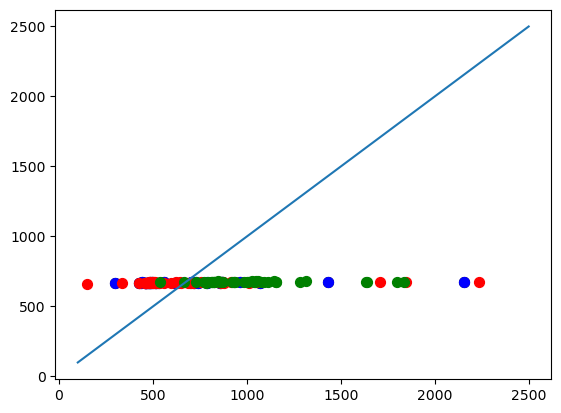

In [34]:

'''Prediction using the best model'''
predict_labels_a=[]
predict_labels_b=[]
predict_labels_train=[]
predict_labels_val = []
model.eval()
with torch.no_grad():
    predict_labels_a.append(model(input_test_a).data.numpy())
    predict_labels_b.append(model(input_test_b).data.numpy())
    
    predict_labels_train.append(model(input_train).data.numpy())   
    predict_labels_val.append(model(input_val).data.numpy())      


actual_label_arr_train=np.round(np.asarray(train_labels*max_label).reshape(-1,1))  
predict_label_arr_train=np.round(np.asarray(predict_labels_train).reshape(-1,1)*max_label)


actual_label_arr_val=np.round(np.asarray(val_labels*max_label).reshape(-1,1))   
predict_label_arr_val=np.round(np.asarray(predict_labels_val).reshape(-1,1)*max_label)


actual_label_arr_a=np.round(np.asarray(test_cycle_life_a*max_label).reshape(-1,1))   
predict_label_arr_a=np.round(np.asarray(predict_labels_a).reshape(-1,1)*max_label)


actual_label_arr_b=np.round(np.asarray(test_cycle_life_b * max_label).reshape(-1,1))   
predict_label_arr_b=np.round(np.asarray(predict_labels_b).reshape(-1,1)*max_label)


'''Plot the predicted cycle lives'''
plt.scatter(actual_label_arr_train, predict_label_arr_train,s=50,c='k')
plt.scatter(actual_label_arr_val, predict_label_arr_val,s=50,c='b')
plt.scatter(actual_label_arr_a, predict_label_arr_a,s=50,c='r')
plt.scatter(actual_label_arr_b, predict_label_arr_b,s=50,c='g')
plt.plot([100,2500],[100,2500])


'''Evaluation metrics'''
mpe_a=np.mean(np.abs(predict_label_arr_a-actual_label_arr_a)/actual_label_arr_a)
mpe_b=np.mean(np.abs(predict_label_arr_b-actual_label_arr_b)/actual_label_arr_b)
mpe_train = np.mean(np.abs(predict_label_arr_train-actual_label_arr_train)/actual_label_arr_train)
mpe_val = np.mean(np.abs(predict_label_arr_val-actual_label_arr_val)/actual_label_arr_val)


rmse_a=np.sqrt(np.mean((predict_label_arr_a-actual_label_arr_a)**2))
rmse_b=np.sqrt(np.mean((predict_label_arr_b-actual_label_arr_b)**2))
rmse_train=np.sqrt(np.mean((predict_label_arr_train-actual_label_arr_train)**2))
rmse_val=np.sqrt(np.mean((predict_label_arr_val-actual_label_arr_val)**2))


print ('mpe_train:',mpe_train)
print ('mpe_val:',mpe_val)
print ('mpe_a:',mpe_a)
print ('mpe_b:',mpe_b)

print ('rmse_train:', rmse_train)
print ('rmse_val:', rmse_val)
print ('rmse_a:', rmse_a)
print ('rmse_b:', rmse_b)

In [35]:
from sklearn.metrics import r2_score
r2_a = r2_score(actual_label_arr_a, predict_label_arr_a)
r2_b = r2_score(actual_label_arr_b, predict_label_arr_b)
r2_train = r2_score(actual_label_arr_train, predict_label_arr_train)
r2_val = r2_score(actual_label_arr_val, predict_label_arr_val)

print('r2_train:', r2_train)
print('r2_val:', r2_val)
print('r2_a:', r2_a)
print('r2_b:', r2_b)

r2_train: -0.0034104585647583008
r2_val: 0.0054708123207092285
r2_a: -0.0032329260759380585
r2_b: -1.4502091015101626
